# 최근 영화 평점 분석, 그런데 이제 웹크롤링을 곁들인

최근에 배운 데이터 긁어오기(유사 웹크롤링)을 이용해서 영화 평점을 분석하고,

내가 좋아하는 영화들의 평점 추이를 살펴보도록 하자!

```추신 : 재미로 한거니, 그냥 이 사람이 이런걸 배워서 써먹어보는거구나~ 하고 봐주세요!```

## 1. 네이버 영화 사이트 분석

네이버 영화 사이트를 통해서, 최근 100일간의 영화 평점을 긁어와서 분석을 해보도록 하자!

In [2]:
# requirements
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup

##### BeautifulSoup을 이용해서 내용을 불러오자

In [3]:
url = 'https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date=20210929'
response = urlopen(url)
soup = BeautifulSoup(response, 'html.parser')
response.status  # 200번대면 정상이라는 소리다!
# print(soup.prettify())

200

네이버 영화 사이트에 들어가서, F12를 이용해 제목과 평점이 들어간 태그와 클래스를 조사해봤더니..

In [4]:
# 영화 제목, 평점 태그
soup.find_all("div", class_='tit5')[0].a.string, soup.find_all('td',class_= 'point')[0].string

('밥정', '9.63')

In [5]:
# 영화 제목과 평점의 개수 확인
len(soup.find_all("div", class_='tit5')), len(soup.find_all('td',class_= 'point'))

(47, 47)

잘 긁어와진 것 같다!

##### 영화 제목과 평점 리스트

In [6]:
end = len(soup.find_all("div", class_ = "tit5"))
movie_name = [soup.find_all("div", class_="tit5")[n].a.string 
              for n in range(0,end)]

end = len(soup.find_all('td', class_='point'))
movie_point = [soup.find_all('td', class_='point')[n].string
              for n in range(0,end)]

movie_name[:5], movie_point[:10]

(['밥정', '원더', '코다', '해리 포터와 마법사의 돌', '기적'],
 ['9.63',
  '9.53',
  '9.35',
  '9.35',
  '9.29',
  '9.24',
  '9.22',
  '9.19',
  '9.17',
  '9.11'])

## 2. 자동화를 위한 코드

```
'https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date=20210929'

```
- 날짜만 변경하면 우리가 원하는 기간 만큼 데이터를 얻을 수 있다!

오늘을 기준으로 최근 100일 간의 데이터를 불러와보자!

In [7]:
date = pd.date_range('2021.06.22', periods=100, freq="D")
date[:5]

DatetimeIndex(['2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-26'],
              dtype='datetime64[ns]', freq='D')

이제 이 날짜들을 주소 맨 뒤에 YYYYMMDD 자리에 넣어야 하는데,,,

In [8]:
date[0]

Timestamp('2021-06-22 00:00:00', freq='D')

출력해보면, 원하는 형태가 아니다

##### strftime (string from time)을 통해서 원하는 모양의 str타입으로 변환시키자!

In [9]:
date[0].strftime("%Y-%m-%d"), date[0].strftime("%Y.%m.%d")

('2021-06-22', '2021.06.22')

##### 위처럼 만들어놓은 날짜를, 주소에 입력하기 위해 문자열 formatting 기능을 사용해보자!

In [10]:
# 문자열 format 예시

test_string = "Hello, I'm {name}"
test_string.format(name = 'Taeoxo')

"Hello, I'm Taeoxo"

##### 이제 위에서 구한 날짜와, for문을 이용해서 100일간의 영화제목, 평점을 긁어오자

In [11]:
import time
from tqdm import tqdm

movie_date = []
movie_name = []
movie_point = []

for today in tqdm(date):
    url = "https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date={date}"
    response = urlopen(url.format(date=today.strftime('%Y%m%d')))
    soup = BeautifulSoup(response, 'html.parser')
    
    end = len(soup.find_all('div', class_='tit5'))
    # name과 point 둘다 확인해야하지만, 통상적으로 같으니 하나로!
    
    movie_date.extend([today.strftime("%Y-%m-%d") for _ in range(0,end)])
    movie_name.extend([soup.find_all('div','tit5')[n].a.string 
                       for n in range(0,end)])
    movie_point.extend([soup.find_all('td','point')[n].string
                       for n in range(0,end)])
    # 크롤링 시에, 너무 빠른 속도로 데이터를 요청하면
    # 사람이 아닌, 기계의 인위적 접속(사실 맞지만,,,)으로 판단해 차단할 수도 있기에
    # time.sleep()을 통해 약간의 term을 두는 것이 중요하다!
    time.sleep(0.5)
    
    


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


##### 데이터를 모아온 후에는, 데이터의 길이와 일부를 확인해 제대로 모였는지 확인한다.


In [12]:
len(movie_date), len(movie_name), len(movie_point)

(4499, 4499, 4499)

In [13]:
movie_point[:5], movie_name[:5]

(['9.43', '9.30', '9.30', '9.28', '9.19'],
 ['덕구', '부활: 그 증거', '크루엘라', '극장판 귀멸의 칼날: 무한열차편', '해피 투게더'])

In [14]:
# 데이터프레임으로 변환!
movie = pd.DataFrame({
    "date" : movie_date,
    'name' : movie_name,
    'point' : movie_point
})
movie.tail()

,date,name,point
4494,2021-09-29,인질,7.33
4495,2021-09-29,말리그넌트,7.25
4496,2021-09-29,샹치와 텐 링즈의 전설,6.59
4497,2021-09-29,싱크홀,6.55
4498,2021-09-29,"쏘아올린 불꽃, 밑에서 볼까? 옆에서 볼까?",6.51


In [15]:
# pd.DataFrame.info()로 확인을 해보자
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4499 entries, 0 to 4498
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4499 non-null   object
 1   name    4499 non-null   object
 2   point   4499 non-null   object
dtypes: object(3)
memory usage: 105.6+ KB


##### point는 평점인데, 데이터타입이 float가 아니라 object이다. 변경하자!

In [16]:
movie['point'] = movie['point'].astype(float)
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4499 entries, 0 to 4498
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4499 non-null   object 
 1   name    4499 non-null   object 
 2   point   4499 non-null   float64
dtypes: float64(1), object(2)
memory usage: 105.6+ KB


## 3. 영화 평점 데이터 정리

- pivot_table을 통해 영화별 평균평점을 정리해보기
- 100일 간 네이버 영화 평점 평균 기준 Best & Worst 10 선정하기!
- 내가 좋아하는 영화들의 평점 변화 살펴보기!

In [27]:
# pivot table
movie_unique = pd.pivot_table(data = movie, index = 'name', aggfunc = [np.mean, np.std])
movie_unique.columns = ['평점 평균', '평점 표준편차']
movie_unique.head()

,평점 평균,평점 표준편차
007 노 타임 투 다이,7.89,NaN
13 구역,8.70,0.0
47 미터,7.27,0.0
500일의 썸머,8.43,0.0
69세,8.64,0.0


##### 

In [29]:
# Best 10
movie_best = movie_unique.sort_values(by = '평점 평균', ascending=False)
movie_best.head(10)

,평점 평균,평점 표준편차
밥정,9.626667,0.008165
가버나움,9.590000,0.000000
원더,9.530000,0.000000
덕구,9.430000,0.000000
코다,9.369130,0.020206
해리 포터와 마법사의 돌,9.349375,0.002500
피아니스트,9.330000,0.000000
자산어보,9.324286,0.011339
언더독,9.320000,0.000000
모던 타임즈,9.320000,0.000000


In [30]:
# Worst 10
movie_worst = movie_unique.sort_values(by = '평점 평균', ascending=True)
movie_worst.head(10)

,평점 평균,평점 표준편차
킹 오브 프리즘 -샤이니 세븐 스타즈-,2.150000,0.000000
귀문,4.472174,0.138464
블러드,4.940000,0.000000
어른들은 몰라요,4.943846,0.086365
여고괴담 여섯번째 이야기 : 모교,5.214474,0.274617
랑종,5.289655,0.105508
미드나이트,5.435789,0.370890
사냥의 시간,5.670000,0.000000
강변호텔,5.998333,0.005774
미드소마,6.230000,0.000000


### 하나의 영화에 대해서 연습

DataFrame에 쿼리문을 활용하여, 하나의 영화에 해당하는 데이터만 뽑아보자.

쿼리문 작성시에는, `''`와 `""`을 안 겹치도록 잘 활용해서 써야한다!

In [32]:
tmp = movie.query('name == ["노매드랜드"]')
tmp

,date,name,point
22,2021-06-22,노매드랜드,8.49
72,2021-06-23,노매드랜드,8.47
120,2021-06-24,노매드랜드,8.48
173,2021-06-25,노매드랜드,8.48
219,2021-06-26,노매드랜드,8.48
...,...,...,...
4284,2021-09-25,노매드랜드,8.47
4331,2021-09-26,노매드랜드,8.47
4377,2021-09-27,노매드랜드,8.47
4428,2021-09-28,노매드랜드,8.47


In [33]:
# 시각화

# 파이썬 시각화 패키지 불러오기
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# 사용자 운영체제 확인
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

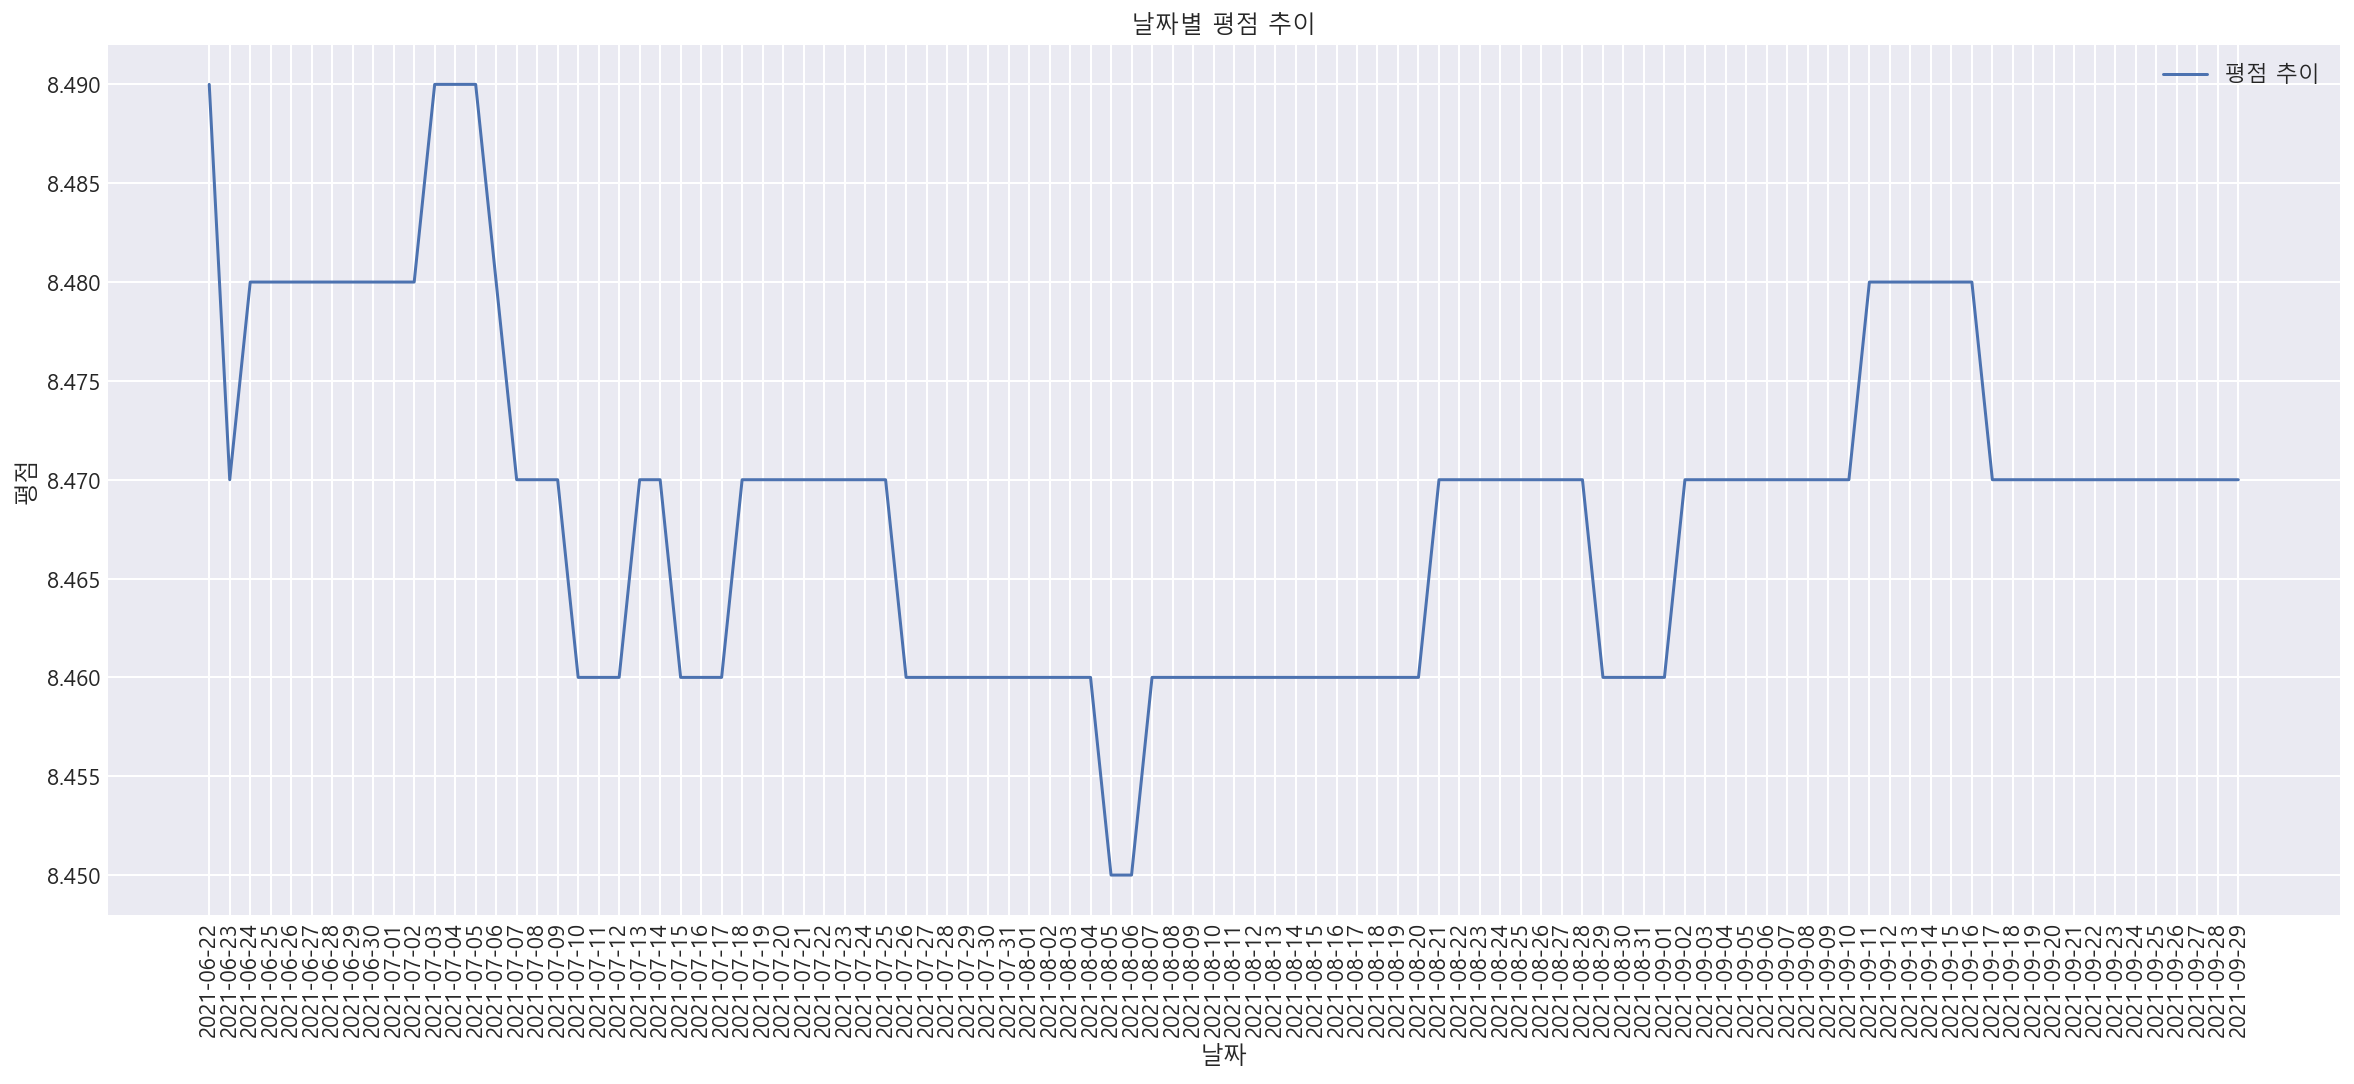

In [35]:
plt.figure(figsize=(20,8))
plt.plot(tmp['date'], tmp['point'])
plt.title("날짜별 평점 추이")
plt.xlabel("날짜")
plt.xticks(rotation="vertical")
plt.ylabel("평점")
plt.legend(labels=['평점 추이'])
plt.show()

### 날짜별 영화 평점 데이터 만들기, plot으로 추이 살펴보기!

##### 우선 Pivot_table을 통해서 날짜를 인덱스로한, 평점 데이터를 만든다!

In [36]:
movie_pivot = pd.pivot_table(data = movie, index = 'date', columns = 'name', values = 'point')
movie_pivot.head()

name,007 노 타임 투 다이,13 구역,47 미터,500일의 썸머,69세,U-571,가버나움,간츠: 오,강변호텔,걸어도 걸어도,...,하나와 앨리스,하하하,한여름의 판타지아,해리 포터와 마법사의 돌,해피 투게더,혐오스런 마츠코의 일생,호우시절,홀리 모터스,화양연화,흐르는 강물처럼
date,,,,,,,,,,,,,,,,,,,,,
2021-06-22,NaN,NaN,NaN,8.43,NaN,NaN,NaN,8.20,5.98,NaN,...,NaN,NaN,NaN,NaN,9.19,NaN,NaN,NaN,8.77,NaN
2021-06-23,NaN,NaN,NaN,8.43,NaN,NaN,NaN,8.19,NaN,NaN,...,NaN,NaN,NaN,NaN,9.19,NaN,NaN,NaN,8.77,NaN
2021-06-24,NaN,NaN,NaN,8.43,NaN,NaN,NaN,8.19,NaN,NaN,...,NaN,NaN,NaN,NaN,9.19,NaN,NaN,NaN,8.77,NaN
2021-06-25,NaN,NaN,NaN,8.43,NaN,NaN,NaN,8.18,NaN,NaN,...,NaN,NaN,NaN,NaN,9.19,NaN,NaN,NaN,8.77,NaN
2021-06-26,NaN,NaN,NaN,8.43,NaN,NaN,NaN,8.18,NaN,NaN,...,NaN,NaN,NaN,NaN,9.19,NaN,NaN,NaN,8.77,NaN


##### 내가 좋아하는 영화들의 평점 추이를, plt.plot을 이용해서 가볍게 살펴보자!

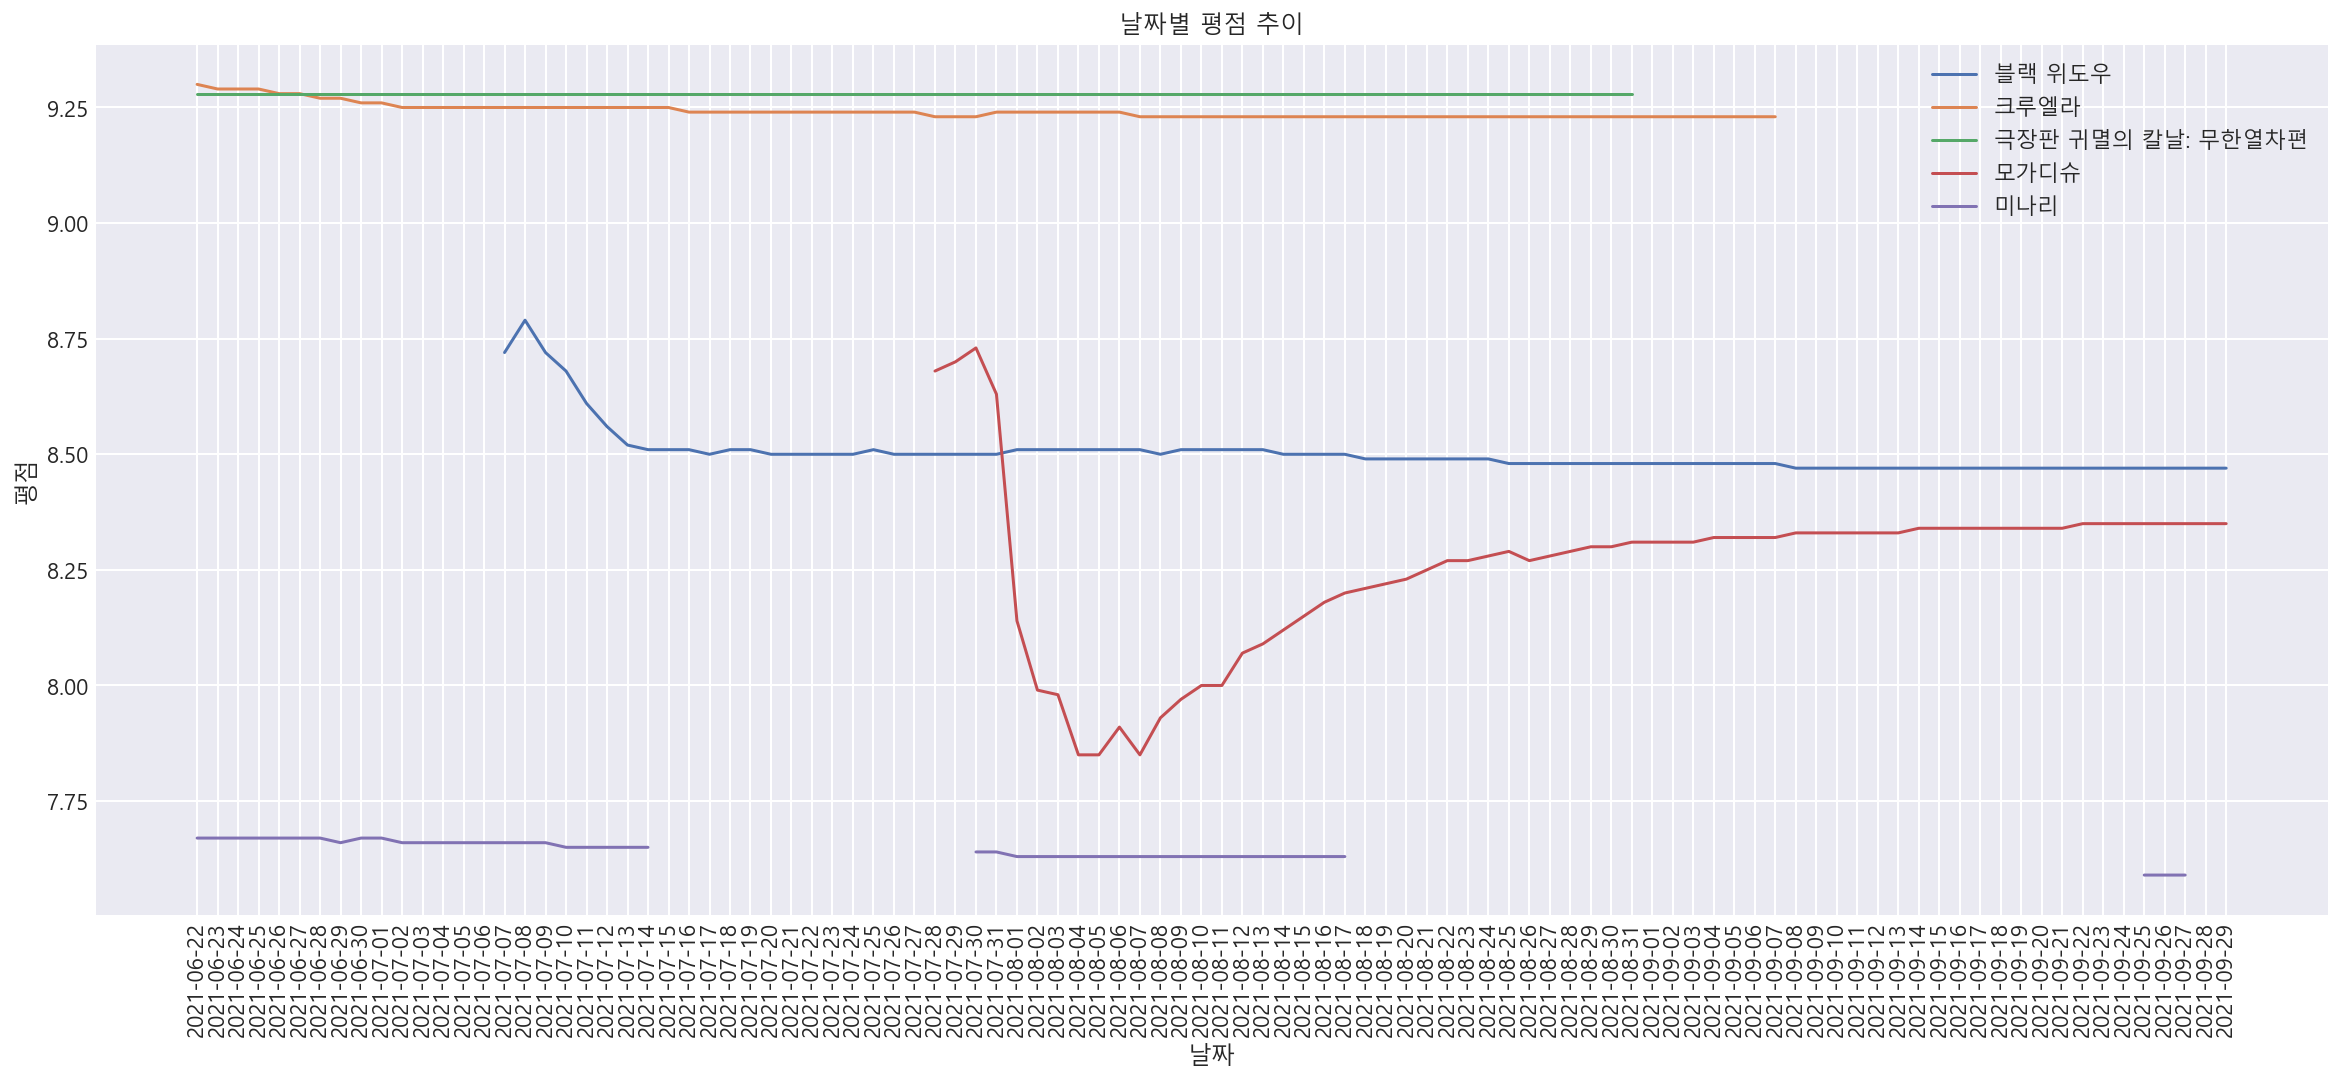

In [37]:
target_movie = ['블랙 위도우', '크루엘라', '극장판 귀멸의 칼날: 무한열차편', '모가디슈', '미나리']
plt.figure(figsize=(20,8))

plt.plot(movie_pivot[target_movie])

plt.title("날짜별 평점 추이")
plt.xlabel("날짜")
plt.xticks(rotation="vertical")
plt.tick_params(bottom='off', labelbottom='off')
plt.ylabel("평점")

plt.legend(target_movie, loc='best')

plt.show()

### 너무나도 간단한 코딩이지만, 내가 원하는 정보를 웹페이지에서 긁어와서, 데이터프레임으로 변환하고 그리는 과정이 앞으로 충분히 유용할 수 있다는 느낌을 받았다! 앞으로도 배운 것 중에서 흥미로운 것들을 종종 업로드 할 예정이다 :)